# POF index

In [1]:
import os
import pandas as pd
import numpy as np
import xarray as xr

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import ipywidgets as widgets
from IPython.display import display, Markdown

## Set my directory

(since it has some problem to recognize the right path)

In [3]:
my_dir = os.getcwd()
print(my_dir)

C:\Users\CAPMAR00\OneDrive - IL Sole 24 Ore SpA\Documenti\marina\ecmwf\cfe-pyroscope\data-analysis


In [4]:
os.chdir(f"{my_dir}")

## Load the NetCDF file

In [9]:
ds = xr.open_dataset("POF_V2_2025_05_13_FC.nc")
print(ds)

<xarray.Dataset>
Dimensions:     (time: 10, lat: 2560, lon: 5136)
Coordinates:
  * time        (time) datetime64[ns] 2025-05-13T11:30:00 ... 2025-05-22T09:0...
  * lat         (lat) float64 89.95 89.88 89.81 89.74 ... -89.81 -89.88 -89.95
  * lon         (lon) float64 -180.0 -179.9 -179.9 -179.8 ... 179.8 179.9 179.9
Data variables:
    MODEL_FIRE  (time, lat, lon) float64 ...


In [10]:
ds['time'].values

array(['2025-05-13T11:30:00.000000000', '2025-05-14T11:30:00.000000000',
       '2025-05-15T11:30:00.000000000', '2025-05-16T09:30:00.000000000',
       '2025-05-17T10:30:00.000000000', '2025-05-18T10:30:00.000000000',
       '2025-05-19T09:00:00.000000000', '2025-05-20T09:00:00.000000000',
       '2025-05-21T09:00:00.000000000', '2025-05-22T09:00:00.000000000'],
      dtype='datetime64[ns]')

In [13]:
ds.data_vars

Data variables:
    MODEL_FIRE  (time, lat, lon) float64 ...

In [15]:
variable_name='MODEL_FIRE'

## Clean data

### Remove infinite and NaN values

In [19]:
def clean_inf_Nan_values(ds, variable_name=variable_name):
    """
    Clean POF data by removing infinite and NaN values
    
    Parameters:
    -----------
    ds : xarray.Dataset
        Original dataset
    variable_name : str
        Name of the POF variable
        
    Returns:
    --------
    ds_clean : xarray.Dataset
        Dataset with cleaned POF data
    """
    print("Cleaning POF data...")
    
    # Get original data
    pof = ds[variable_name]
    
    # Create mask for valid data (finite values only)
    valid_mask = np.isfinite(pof)
    
    # Apply mask - replace invalid values with NaN
    pof_clean = pof.where(valid_mask)
    
    # Create new dataset with cleaned data
    ds_clean = ds.copy()
    ds_clean[variable_name] = pof_clean
    
    # Print cleaning summary
    total_values = pof.size
    valid_count = valid_mask.sum().values
    removed_count = total_values - valid_count
    
    print(f"Data cleaning summary:")
    print(f"- Total values: {total_values:,}")
    print(f"- Valid values: {valid_count:,} ({valid_count/total_values*100:.1f}%)")
    print(f"- Removed values: {removed_count:,} ({removed_count/total_values*100:.1f}%)")
    
    return ds_clean

In [21]:
print("Step 2: Removing infinite and NaN values...")
ds_final = clean_inf_Nan_values(ds)
print(ds_final)

Step 2: Removing infinite and NaN values...
Cleaning POF data...
Data cleaning summary:
- Total values: 131,481,600
- Valid values: 28,506,120 (21.7%)
- Removed values: 102,975,480 (78.3%)
<xarray.Dataset>
Dimensions:     (time: 10, lat: 2560, lon: 5136)
Coordinates:
  * time        (time) datetime64[ns] 2025-05-13T11:30:00 ... 2025-05-22T09:0...
  * lat         (lat) float64 89.95 89.88 89.81 89.74 ... -89.81 -89.88 -89.95
  * lon         (lon) float64 -180.0 -179.9 -179.9 -179.8 ... 179.8 179.9 179.9
Data variables:
    MODEL_FIRE  (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan


## EDA

**Basic Statistical Analysis**

1. Dataset overview (dimensions, coverage, resolution)
2. POF statistics (min, max, mean, std, median)
3. Data quality assessment (NaN counts)

In [33]:
def analyze_dataset(ds, variable_name=variable_name):
    """
    Analyze a POF dataset and return key statistics and data quality info.
    """
    da = ds[variable_name]
    time_dim, lat_dim, lon_dim = da.sizes['time'], da.sizes['lat'], da.sizes['lon']
    total_values = time_dim * lat_dim * lon_dim

    # Flatten data for basic statistics
    data_flat = da.values.flatten()

    is_nan = np.isnan(data_flat)
    is_inf = np.isinf(data_flat)
    is_finite = np.isfinite(data_flat)

    nan_count = int(np.sum(is_nan))
    inf_count = int(np.sum(is_inf))
    valid_count = int(np.sum(is_finite))

    valid_data = data_flat[is_finite]

    stats = {
        'min': float(np.min(valid_data)) if valid_count > 0 else None,
        'max': float(np.max(valid_data)) if valid_count > 0 else None,
        'mean': float(np.mean(valid_data)) if valid_count > 0 else None,
        'std': float(np.std(valid_data)) if valid_count > 0 else None,
        'median': float(np.median(valid_data)) if valid_count > 0 else None,
        'percentiles': {
            '5th': float(np.percentile(valid_data, 5)),
            '25th': float(np.percentile(valid_data, 25)),
            '75th': float(np.percentile(valid_data, 75)),
            '95th': float(np.percentile(valid_data, 95)),
        } if valid_count > 0 else None
    }

    # Temporal coverage: valid values per timestep
    valid_per_time = xr.apply_ufunc(np.isfinite, da).sum(dim=["lat", "lon"]).values
    temporal_coverage = {
        'valid_per_time_min': int(valid_per_time.min()),
        'valid_per_time_max': int(valid_per_time.max()),
        'valid_per_time_mean': float(valid_per_time.mean()),
        'empty_time_steps': int(np.sum(valid_per_time == 0))
    }

    # Spatial coverage: pixels with at least one valid value across time
    valid_mask = xr.apply_ufunc(np.isfinite, da).sum(dim="time") > 0
    pixels_with_data = int(valid_mask.sum().values)
    total_pixels = lat_dim * lon_dim

    spatial_coverage = {
        'pixels_with_data': pixels_with_data,
        'total_pixels': total_pixels,
        'coverage_percentage': 100 * pixels_with_data / total_pixels
    }

    return {
        'statistics': stats,
        'data_quality': {
            'total_values': total_values,
            'valid_values': valid_count,
            'nan_values': nan_count,
            'inf_values': inf_count,
            'valid_percentage': 100 * valid_count / total_values
        },
        'temporal_coverage': temporal_coverage,
        'spatial_coverage': spatial_coverage
    }

In [35]:
stats = analyze_dataset(ds_final)
stats

{'statistics': {'min': 0.0,
  'max': 0.7170931100845337,
  'mean': 0.0038666127407587583,
  'std': 0.010582066616900023,
  'median': 0.0006991102709434927,
  'percentiles': {'5th': 8.506031917931978e-06,
   '25th': 9.169707482215017e-05,
   '75th': 0.0032356883748434484,
   '95th': 0.016796639282256248}},
 'data_quality': {'total_values': 131481600,
  'valid_values': 28506120,
  'nan_values': 102975480,
  'inf_values': 0,
  'valid_percentage': 21.68069144275701},
 'temporal_coverage': {'valid_per_time_min': 2850612,
  'valid_per_time_max': 2850612,
  'valid_per_time_mean': 2850612.0,
  'empty_time_steps': 0},
 'spatial_coverage': {'pixels_with_data': 2850612,
  'total_pixels': 13148160,
  'coverage_percentage': 21.68069144275701}}

## Data visualizations

* Global maps: POF at first/last time steps and time-averaged
* Distribution: Histogram of POF values
* Temporal evolution: Global mean POF over time
* Regional focus: Example for Australia region
* Latitudinal patterns: POF variation by latitude
* Variability: Temporal variance in POF
* High-risk areas: Top 5% fire risk regions

 ### 1. Global map (snapshot)

In [31]:
def plot_global_map(ds, time_index=0, vmin=None, vmax=None):
    fire = ds[variable_name].isel(time=time_index)
    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    fire.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='hot', vmin=vmin, vmax=vmax)
    ax.coastlines()
    ax.set_title(f"Global Fire Model - {str(ds.time.values[time_index])}")
    plt.show()

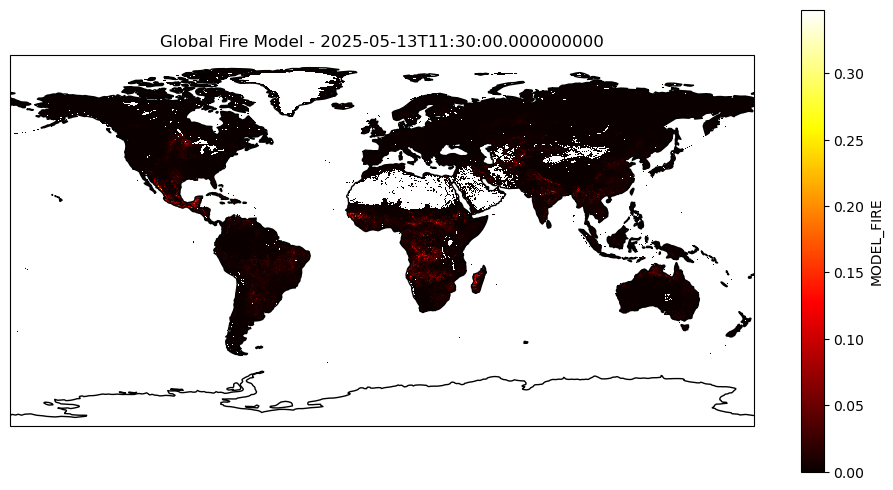

In [33]:
plot_global_map(ds_final)

### 2. Distribution (histogram)

In [39]:
def plot_distribution(ds, time_index=0):
    data = ds[variable_name].isel(time=time_index).values.flatten()
    data = data[~np.isnan(data)]
    plt.figure(figsize=(8, 4))
    sns.histplot(data, bins=100, kde=True)
    plt.title(f"Distribution of MODEL_FIRE - {str(ds.time.values[time_index])}")
    plt.xlabel("MODEL_FIRE")
    plt.ylabel("Frequency")
    plt.show()

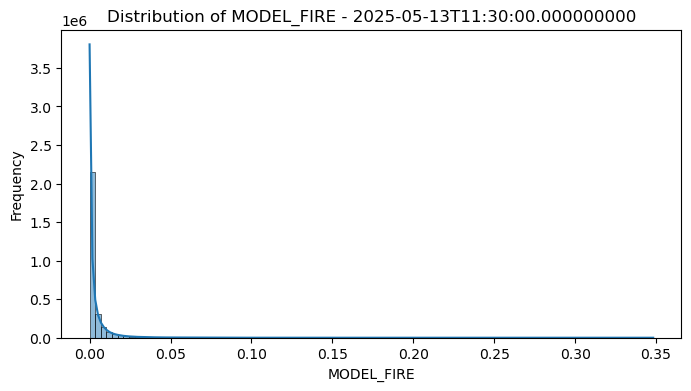

In [41]:
plot_distribution(ds_final)

### 3. Temporal evolution (global mean)

In [48]:
def plot_temporal_evolution(ds):
    time_series = ds[variable_name].mean(dim=["lat", "lon"])
    plt.figure(figsize=(10, 4))
    time_series.plot(marker='o')
    plt.title("Temporal Evolution of Global Mean Fire Activity")
    plt.ylabel("MODEL_FIRE")
    plt.xlabel("Time")
    plt.grid(True)
    plt.show()

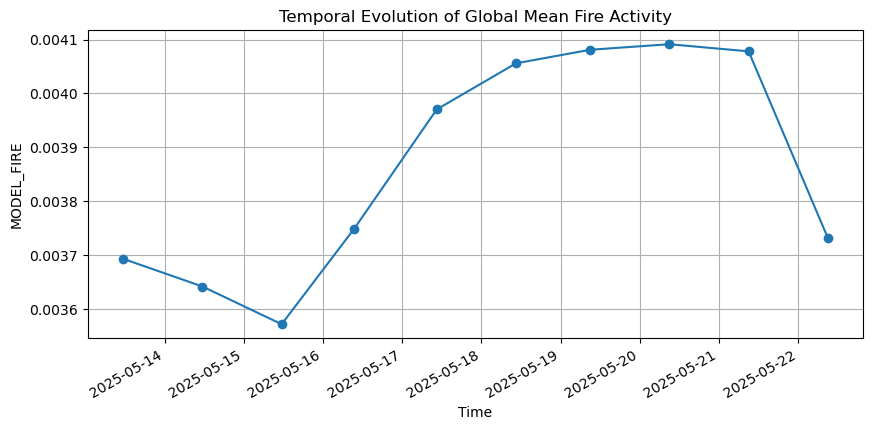

In [50]:
plot_temporal_evolution(ds_final)

###  4. Regional focus

In [58]:
def plot_regional_focus(ds, lat_bounds, lon_bounds, time_index=0):
    # Nearest selection to actual coordinate values
    region = ds[variable_name].isel(time=time_index).sel(
        lat=slice(lat_bounds[0], lat_bounds[1]),
        lon=slice(lon_bounds[0], lon_bounds[1])
    )

    if region.count().values == 0:
        raise ValueError("Selected region contains no data. Check bounds or coordinate resolution.")

    fig = plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    region.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='hot')
    ax.coastlines()
    ax.set_title(f"Regional Focus - {str(ds.time.values[time_index])}")
    ax.set_extent([lon_bounds[0], lon_bounds[1], lat_bounds[1], lat_bounds[0]], crs=ccrs.PlateCarree())
    plt.show()

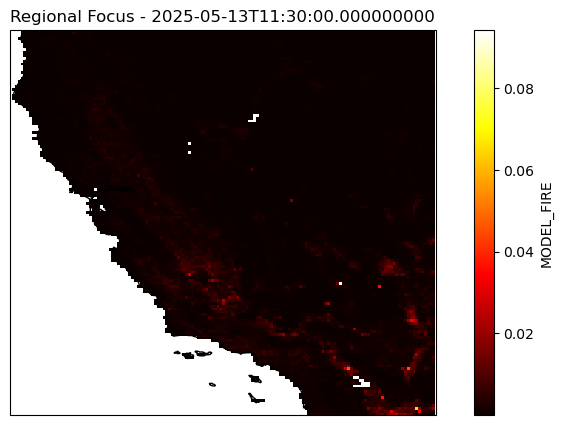

In [64]:
plot_regional_focus(ds_final, lat_bounds=(42.0, 32.5), lon_bounds=(-124.5, -114.0), time_index=0) # California

### 5. Latitudinal patterns (mean across longitude)

In [70]:
def plot_latitudinal_pattern(ds):
    lat_profile = ds[variable_name].mean(dim=['time', 'lon'])
    plt.figure(figsize=(8, 4))
    lat_profile.plot()
    plt.title("Latitudinal Pattern of Fire Activity")
    plt.xlabel("Latitude")
    plt.ylabel("Mean MODEL_FIRE")
    plt.grid(True)
    plt.show()

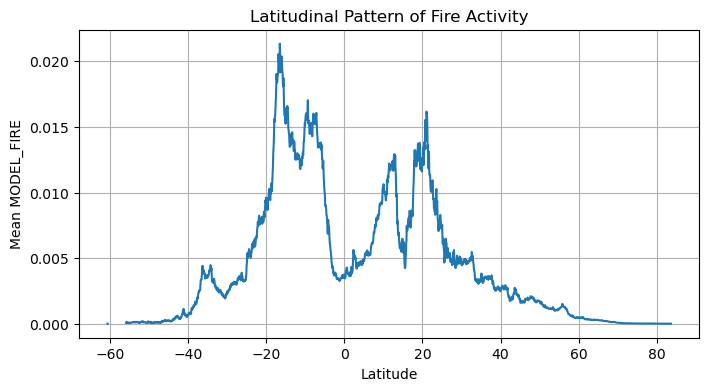

In [72]:
plot_latitudinal_pattern(ds_final)

### 6. Variability (standard deviation)

In [74]:
def plot_variability(ds):
    std_map = ds[variable_name].std(dim='time')
    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    std_map.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis')
    ax.coastlines()
    ax.set_title("Temporal Variability (STD) of Fire Activity")
    plt.show()

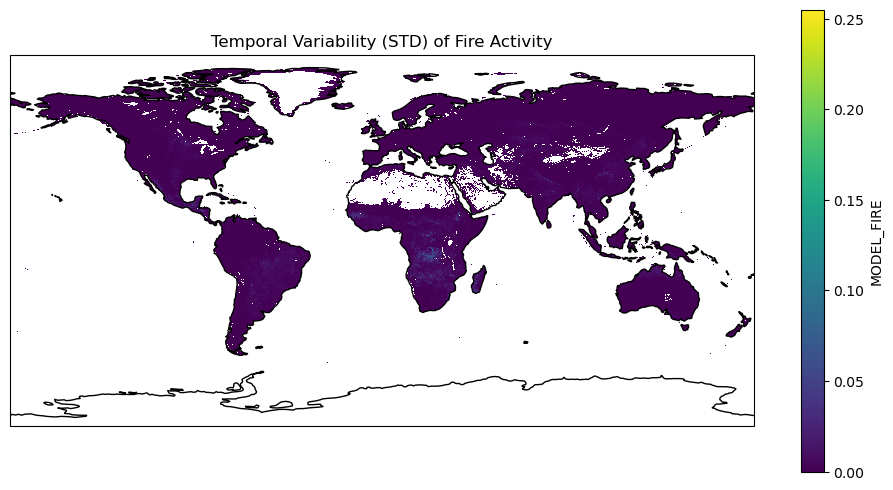

In [76]:
plot_variability(ds_final)

### 7. High-risk areas (Top N% globally)

In [79]:
def plot_high_risk_areas(ds, percentile=95):
    mean_fire = ds[variable_name].mean(dim='time')
    threshold = np.nanpercentile(mean_fire, percentile)
    high_risk_mask = mean_fire.where(mean_fire >= threshold)

    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    high_risk_mask.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Reds')
    ax.coastlines()
    ax.set_title(f"High-Risk Areas (Top {100 - percentile}% of Fire Activity)")
    plt.show()

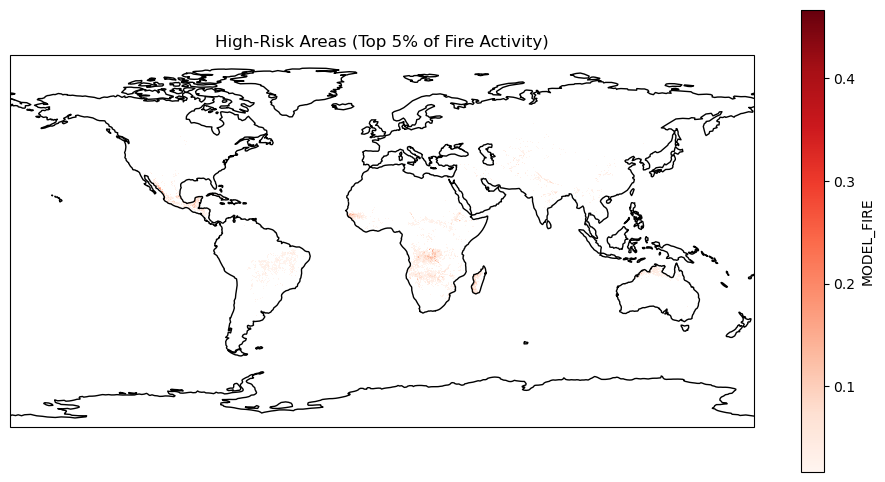

In [81]:
plot_high_risk_areas(ds_final)